In [1]:
from pathlib import Path ; import numpy as np ; import flopy ; import matplotlib.pyplot as plt ; import flopy.utils.binaryfile as bf

In [2]:
sim_name = Path("./03_tut02_Unconfined")    ; sim_name.mkdir(exist_ok=True) ; name = modelname = "tutorial02_B"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'                           ; workspace  = output_folder = model_ws = ws = sim_name

In [3]:
Lx, Ly  = 1000.0 , 1000.0 ; ztop, zbot = 10.0, -50.0            ; nlay, nrow, ncol = 1, 10, 20
delr, delc, delv  = Lx/ncol, Ly/nrow, (ztop-zbot)/nlay          ; botm  = np.linspace(ztop, zbot, nlay + 1)
nper    = 3 ; perlen = [1, 100, 100] ; nstp = [1, 100, 100]     ; steady = [True, False, False]
ibound  = np.ones((nlay, nrow, ncol), dtype=np.int32)           ; strt = 10.0 * np.ones((nlay, nrow, ncol), dtype=np.float32)
hk, vka, sy, ss, laytyp = 1.0, 1.0, 0.1, 1.0e-4, 1   

In [4]:
B   = flopy.modflow.Modflow(name, exe_name=exe_name, model_ws=workspace)
dis = flopy.modflow.ModflowDis(B, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, 
                               top=ztop, botm=botm[1:], nper=nper, perlen=perlen, nstp=nstp, steady=steady)
bas = flopy.modflow.ModflowBas(B, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf( B, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)    # laytyp ______  confined (0)
pcg = flopy.modflow.ModflowPcg(B)  ; B.write_input() 

In [5]:
stageleft, stageright = 10.0, 10.0  ; stageleft, stageright = 10, 0
bound_sp1, bound_sp2 = [], []       ; stress_period_data = {0: bound_sp1, 1: bound_sp2}
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc                ; condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])   ; bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print("Adding ", len(bound_sp1), "GHBs for stress period 1.")    
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc               ; condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])  ; bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print("Adding ", len(bound_sp2), "GHBs for stress period 2.")

ghb = flopy.modflow.ModflowGhb(B, stress_period_data=stress_period_data) ; B.write_input()  

Adding  20 GHBs for stress period 1.
Adding  20 GHBs for stress period 2.


In [6]:
pumping_rate = -500.0
wel_sp1 = [[0, nrow / 2 - 1, ncol / 2 - 1, 0.0]]                         ; wel_sp2 = [[0, nrow / 2 - 1, ncol / 2 - 1, 0.0]]
wel_sp3 = [[0, nrow / 2 - 1, ncol / 2 - 1, pumping_rate]]                ;stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(B, stress_period_data=stress_period_data)  ; B.write_input()  

In [7]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc( B, stress_period_data=stress_period_data, compact=True)  ; B.write_input()
success, Boutput = B.run_model(silent=True, pause=False)   ; assert success, "D'oh."

In [8]:
headobj = bf.HeadFile(Path(workspace) / f"{name}.hds")  ; times = headobj.get_times() ; cbb = bf.CellBudgetFile(Path(workspace) / f"{name}.cbc")
levels = np.linspace(0,10,11)  ;extent=(delr/2.0 ,Lx-delr/2.0 ,delc/2.0 ,Ly-delc/2.0) ; print("Levels: ",levels) ; print("Extent: ",extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (25.0, 975.0, 50.0, 950.0)


In [9]:
wpt = (450.0, 550.0) ; mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print("*****Processing time: ", time) ;    head = headobj.get_data(totim=time)
    print("Head statistics") ;print("  min: ", head.min()) ;print("  max: ", head.max()) ; print("  std: ", head.std())

*****Processing time:  1.0
Head statistics
  min:  0.011554354
  max:  9.990372
  std:  3.0251403
*****Processing time:  101.0
Head statistics
  min:  0.01155439
  max:  9.990372
  std:  3.0251403
*****Processing time:  201.0
Head statistics
  min:  0.009529098
  max:  9.98985
  std:  3.0506117


In [10]:
frf = cbb.get_data(text="FLOW RIGHT FACE", totim=time)[0]   ; fff = cbb.get_data(text="FLOW FRONT FACE", totim=time)[0]

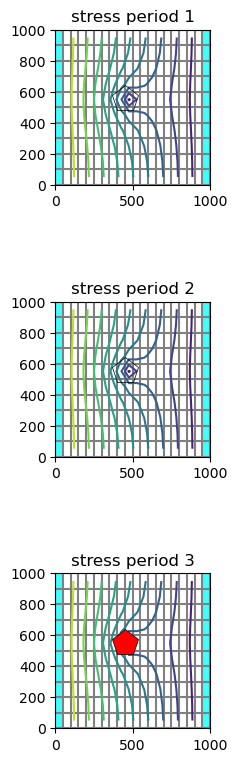

In [13]:
fig = plt.figure(figsize=(2, 10))      ; mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    ax = fig.add_subplot(len(mytimes), 1, iplot + 1, aspect="equal")  ; ax.set_title(f"stress period {iplot + 1}")
    pmv = flopy.plot.PlotMapView(model=B, layer=0, ax=ax)  ;qm = pmv.plot_ibound() ; qm = pmv.plot_bc("GHB", alpha=0.5) ;  lc = pmv.plot_grid() 
    if head.min() != head.max():
        cs = pmv.contour_array(head, levels=levels) # plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f") ; quiver = pmv.plot_vector(frf, fff)
    Bc = "None"
    if (iplot + 1) == len(mytimes):
        Bc = "red"
    ax.plot(wpt[0], wpt[1], lw=0, marker="p", markersize=20, markeredgewidth=0.5,
        markeredgecolor="black", markerfacecolor=Bc, zorder=9,)     # ax.text(wpt[0] + 25, wpt[1] - 25, "well", size=12, zorder=12)

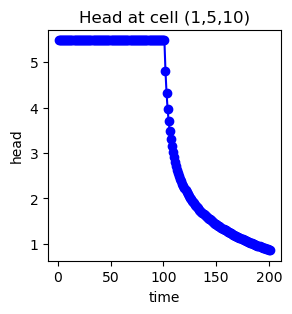

In [12]:
idx = (0, int(nrow / 2) - 1, int(ncol / 2) - 1) ; ts = headobj.get_ts(idx)   ; fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)                   ; ttl = f"Head at cell ({idx[0] + 1},{idx[1] + 1},{idx[2] + 1})"   
ax.set_title(ttl)  ; ax.set_xlabel("time")      ; ax.set_ylabel("head")      ; ax.plot(ts[:, 0], ts[:, 1], "bo-")